In [10]:
import sys
import matplotlib.pyplot as plt
import os

sys.path.append('/home/davcic/CP_Testing')
args = 2
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

from load_dataset import TimeSeries
import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk
import pandas as pd

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel
plt.style.use('default')

Selected GPU 2


In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic, Discontinuous_multiple_params_hyper_linear
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod

In [4]:
readname = 'jfk_passengers'
savename = "jfk_passengers"
path = f'./{savename}'
# os.mkdir(path)

468


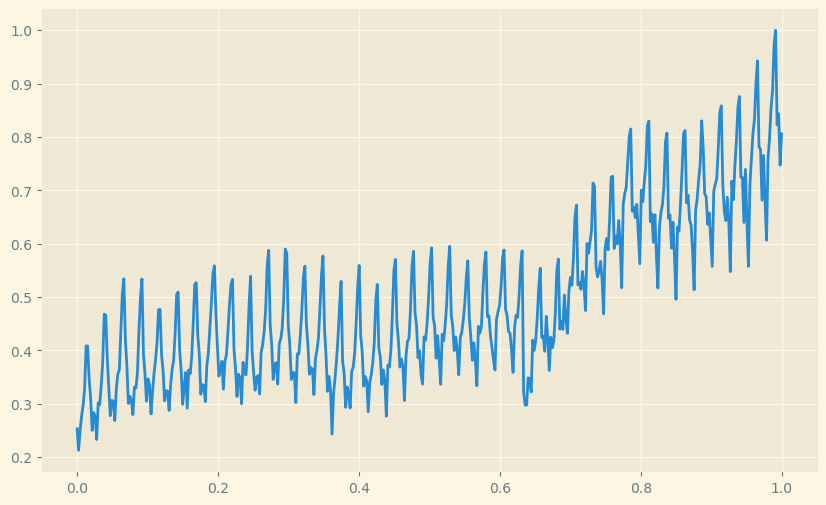

In [5]:
data = TimeSeries.from_json(f'datasets/{readname}/{readname}.json')
fig = plt.figure(figsize = (10, 6))
# y_data = data.y[15:]
print(len(data.y))
# x_data = data.t[15:]-15
corr_data = data.y/jnp.max(data.y)
plt.plot(data.t/(len(data.t)-1), corr_data)
# plt.show()
# plt.savefig(f"{savename}/{savename}_data")
# print(data.datestr)
# print(int(data.datestr[-1][:-3]))

In [13]:
key = jrnd.PRNGKey(123456)

size = 10
T = 1
max_CP = size
base_kernel1 = jk.Periodic()
base_kernel2 = jk.Linear()

# kernel = Discontinuous_multiple_params_hyper(base_kernel1)
# kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel2)
kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel1) + Discontinuous_multiple_params_hyper_linear(base_kernel2)

priors = dict(kernel= [dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                              variance=LogNormal_mod(0, 2, max_CP+1),
                              period=LogNormal_mod(0, 2, max_CP+1),
                              num=Poisson_Process_hyper(size, T)),
                        dict(variance=LogNormal_mod(0, 2, max_CP+1), 
                           num=Poisson_Process_hyper(size, T))],
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
              hyper = [dict(hyper_1 = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())), 
                       dict(hyper_2 = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()))])

x = jnp.array(data.t/(len(data.t)-1))[:, jnp.newaxis]
y = corr_data.flatten()
gp_marginal = FullMarginalGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

num_particles = 1000
num_mcmc_steps = 100

In [14]:
# key, gpm_key = jrnd.split(key)
# mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
#                                                                   mode='gibbs-in-smc',
#                                                                   sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps), 
#                                                                   poisson = True)

In [15]:
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 100
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [16]:
key, subkey = jrnd.split(key)
GP_marginal.model_GP(subkey)

Running Marginal GP
No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01


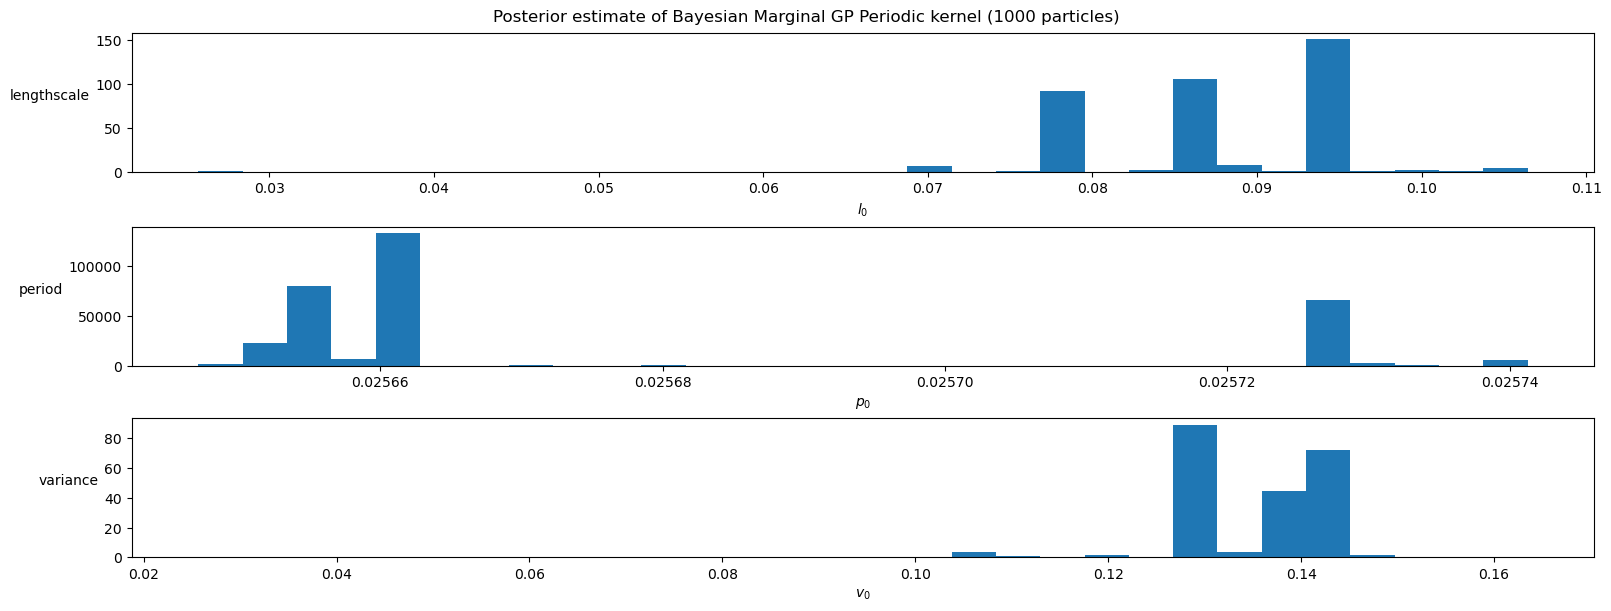

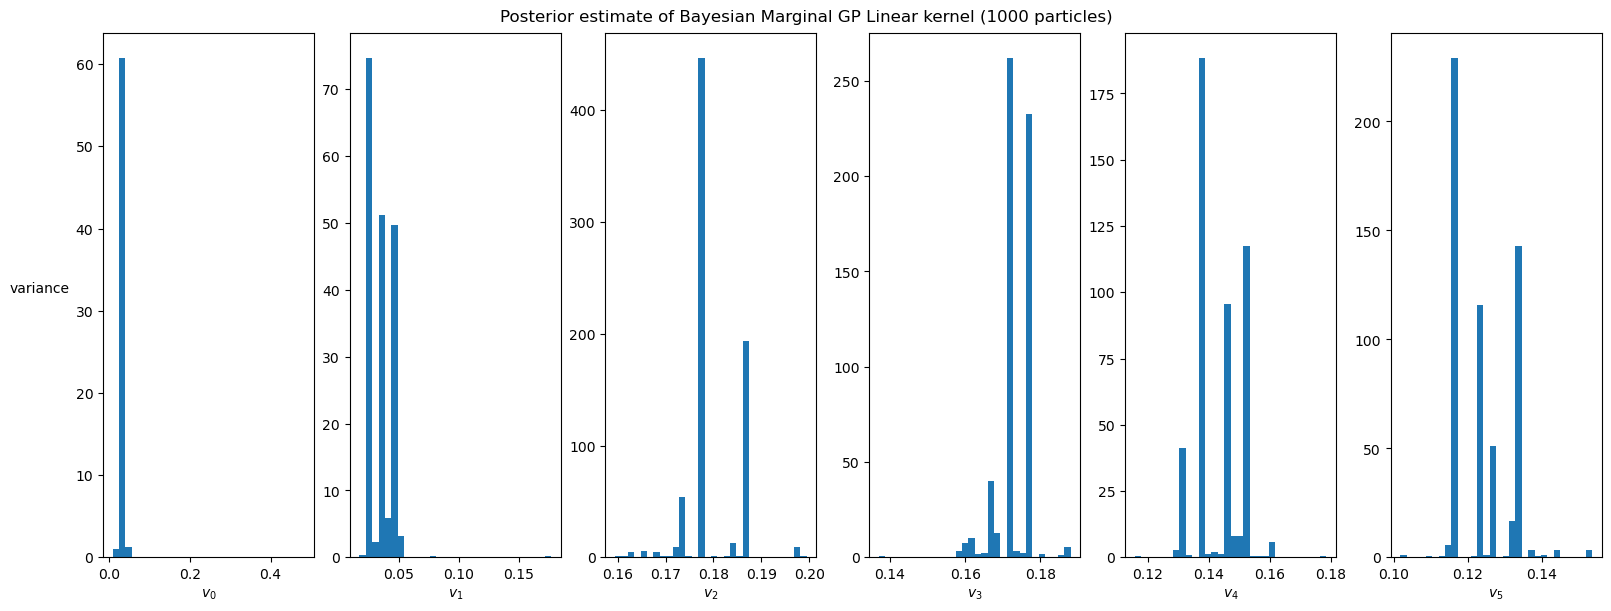

In [25]:
GP_marginal.plot_post()

In [26]:
import gc
gc.collect()

41469

2024-05-29 14:08:23.859843: W external/xla/xla/service/hlo_rematerialization.cc:2202] Can't reduce memory use below 16.62GiB (17845026816 bytes) by rematerialization; only reduced to 21.84GiB (23454522080 bytes), down from 18.58GiB (19950138104 bytes) originally
2024-05-29 14:08:34.356767: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 21.84GiB (rounded to 23447021568)requested by op 
2024-05-29 14:08:34.357129: W external/tsl/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2024-05-29 14:08:34.357534: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 23447021392 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   515.6KiB
              constant allocation:    18.3KiB
        maybe_live_out 

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 23447021392 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   515.6KiB
              constant allocation:    18.3KiB
        maybe_live_out allocation:    3.57MiB
     preallocated temp allocation:   21.84GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   21.84GiB
              total fragmentation:    1.63GiB (7.47%)
Peak buffers:
	Buffer 1:
		Size: 1.63GiB
		Operator: op_name="jit(<lambda>)/jit(main)/mul" source_file="/home/davcic/CP_Testing/New_kernel_1.py" source_line=661
		XLA Label: broadcast
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 2:
		Size: 1.63GiB
		Operator: op_name="jit(<lambda>)/jit(main)/broadcast_in_dim[shape=(1000, 468, 468, 1, 1) broadcast_dimensions=(1, 2, 3, 4)]" source_file="/home/davcic/CP_Testing/New_kernel_1.py" source_line=670
		XLA Label: broadcast
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 3:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 4:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 5:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 6:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 7:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 8:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 9:
		Size: 1.63GiB
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 10:
		Size: 1.63GiB
		Operator: op_name="jit(<lambda>)/jit(main)/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(5,), collapsed_slice_dims=(0, 1, 2, 3, 4), start_index_map=(0, 1, 2, 3, 4, 5)) slice_sizes=(1, 1, 1, 1, 1, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/home/davcic/CP_Testing/New_kernel_1.py" source_line=658
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 11:
		Size: 1.63GiB
		Operator: op_name="jit(<lambda>)/jit(main)/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(5,), collapsed_slice_dims=(0, 1, 2, 3, 4), start_index_map=(0, 1, 2, 3, 4, 5)) slice_sizes=(1, 1, 1, 1, 1, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/home/davcic/CP_Testing/New_kernel_1.py" source_line=658
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 12:
		Size: 1.63GiB
		Operator: op_name="jit(<lambda>)/jit(main)/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(5,), collapsed_slice_dims=(0, 1, 2, 3, 4), start_index_map=(0, 1, 2, 3, 4, 5)) slice_sizes=(1, 1, 1, 1, 1, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/home/davcic/CP_Testing/New_kernel_1.py" source_line=658
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 13:
		Size: 1.63GiB
		Operator: op_name="jit(<lambda>)/jit(main)/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(5,), collapsed_slice_dims=(0, 1, 2, 3, 4), start_index_map=(0, 1, 2, 3, 4, 5)) slice_sizes=(1, 1, 1, 1, 1, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/home/davcic/CP_Testing/New_kernel_1.py" source_line=657
		XLA Label: fusion
		Shape: f64[1,1,1000,468,468]
		==========================

	Buffer 14:
		Size: 208.88MiB
		XLA Label: fusion
		Shape: pred[1,1,1000,468,468]
		==========================

	Buffer 15:
		Size: 208.88MiB
		XLA Label: fusion
		Shape: pred[1,1,1000,468,468]
		==========================



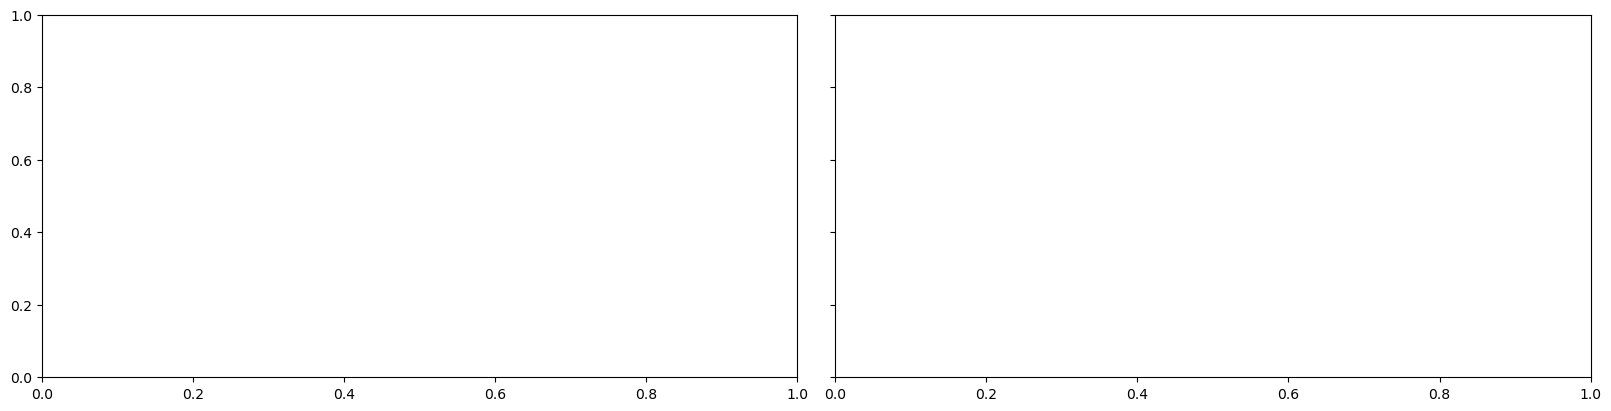

In [29]:
GP_marginal.plot_fit(key, predict = False)

In [33]:
jnp.save(f"{savename}/{savename}_particles_lin_per", GP_marginal.gp_fit.get_monte_carlo_samples())

In [112]:
dist = dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp())
obs_data = mgp_particles.particles['likelihood']['obs_noise']
dist.log_prob(obs_data)
jnp.sum(dist.log_prob(obs_data))

Array(nan, dtype=float64)

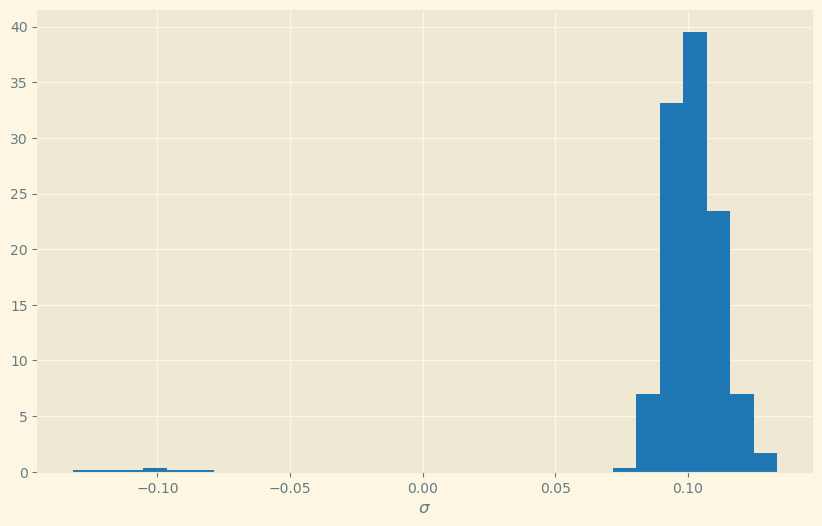

In [113]:
plt.style.use('Solarize_Light2')
fig = plt.figure(figsize = (10, 6))
pd = mgp_particles.particles['likelihood']['obs_noise']
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
plt.hist(pd, bins=30, density=True, color='tab:blue')
# plt.set_ylabel('obs_noise', rotation=0, ha='right')
plt.xlabel(r'${:s}$'.format('\sigma'))
plt.show()

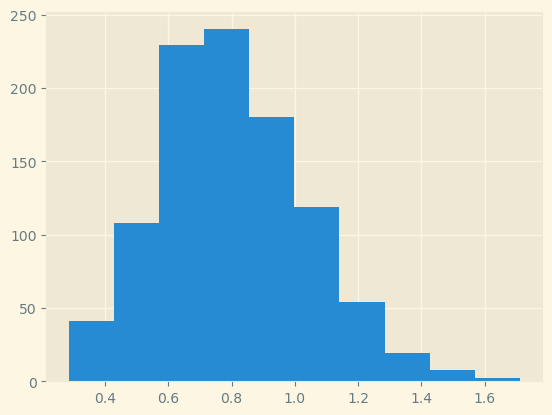

In [114]:
plt.hist(mgp_particles.particles['hyper']['hyper_pp'])
plt.show()

Text(0, 0.5, 'variance')

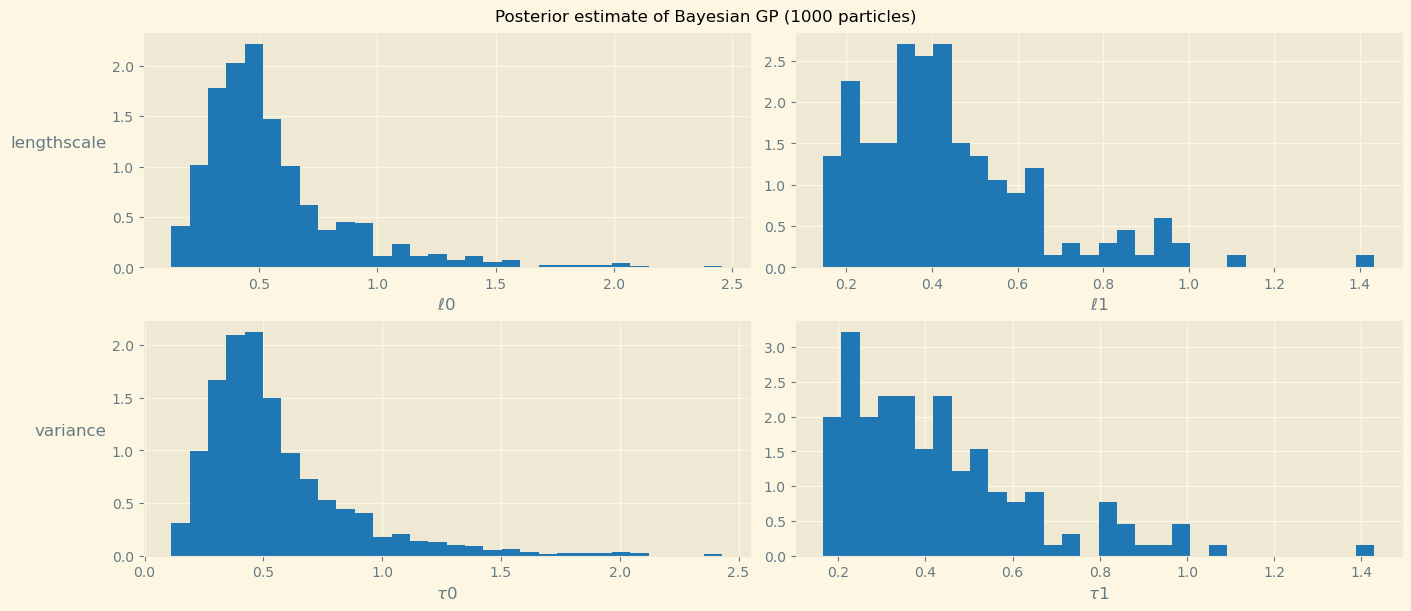

In [115]:
trainables = ['lengthscale', 'variance']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')
max_CP = 1

_, axes = plt.subplots(nrows=num_params, ncols=max_CP+1, constrained_layout=True,
                    figsize=(14, 6))


# particles = mgp_particles
tr = dict(lengthscale=mgp_particles.particles['kernel']['lengthscale'],
            variance=mgp_particles.particles['kernel']['variance'],
            # period = mgp_particles.particles['kernel']['period']
            )
            
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(max_CP+1):
      axes[j, i].hist(pd[:, i], bins=30, density=True, color='tab:blue')
      # axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')
# axes[2, 0].set_ylabel('period', rotation=0, ha='right')

# plt.savefig(f"{savename}/{savename}_posteriors_periodic")

In [116]:
# index_ls = jnp.array([i for i, s in enumerate(data.datestr) if '-01' in s])/data.n_obs
idx = jnp.round(jnp.linspace(0, len(data.datestr) - 1, 8)).astype(int)
labels = data.datestr[idx]
indices = jnp.linspace(0, 1, 8)
print(labels)
print(indices)

['1871' '1885' '1899' '1913' '1928' '1942' '1956' '1970']
[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]


In [117]:
# print(y)
# print(x)

Text(0, 0.5, 'Volume at Aswan\nnile')

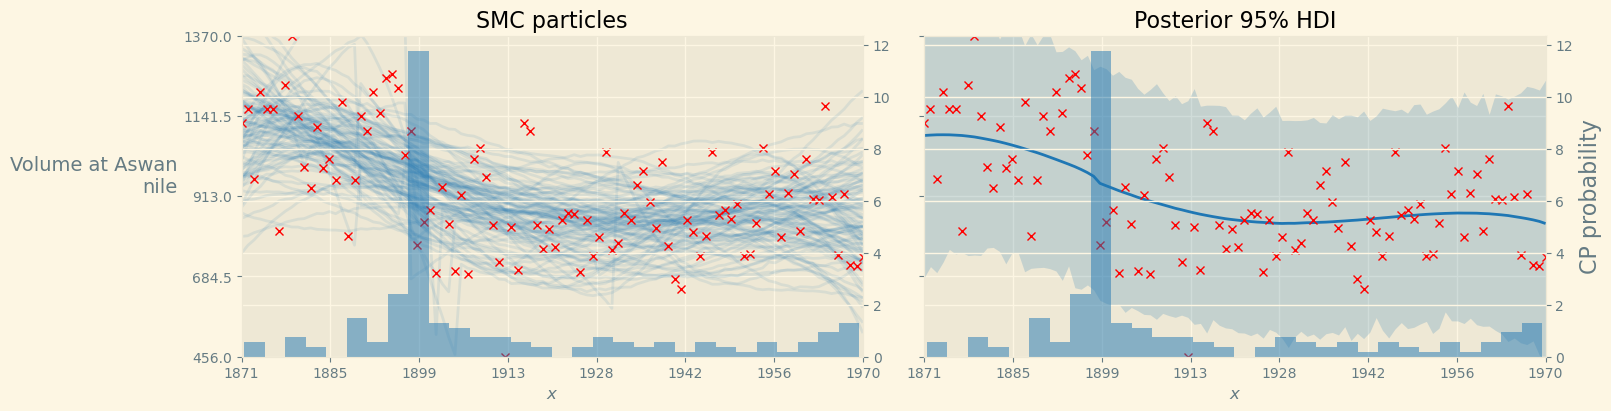

In [118]:
# x_pred = jnp.linspace(-0.25, 1.25, num=150)
x_pred = jnp.linspace(-0, 1, num=100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
pd_filtered = jnp.extract(pd>pd_l, pd)
pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
obs_noise = mgp_particles.particles['likelihood']['obs_noise']
f_mean = jnp.nanmean(f_pred, axis=0)
y_pred = gp_marginal.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.nanpercentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.nanpercentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = f_mean - 1.96*jnp.mean(obs_noise)
# f_hdi_upper = f_mean + 1.96*jnp.mean(obs_noise)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    # ax.plot(qc1.t, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([0, 1])
    ax.set_ylim([jnp.min(corr_data), jnp.max(corr_data)])
    ax.set_xticks(indices, labels = labels)
    ax.set_yticks(jnp.linspace(jnp.min(corr_data), jnp.max(corr_data), 5), labels = jnp.round(jnp.linspace(jnp.min(data.y), jnp.max(data.y), 5), 3))
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel(f"{data.columns[0]}" "\n" f"{readname}", rotation=0, ha='right', fontsize=14)

# plt.savefig(f"{savename}/{savename}_fit_periodic")

In [119]:
# jnp.sum(jnp.isnan(y_pred))

In [25]:
# data.datestr

Text(0, 0.5, 'Amount of particles')

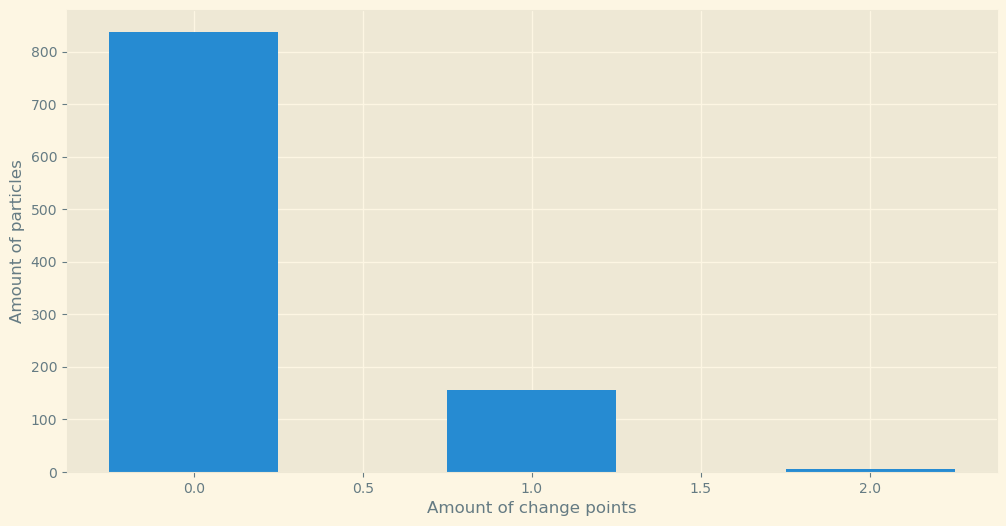

In [59]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")

# plt.savefig(f"{savename}/{savename}_#CP_periodic")